In [1]:
!pip install nsepy
#for downloading dataset

In [2]:
from sklearn.metrics import confusion_matrix

In [3]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Initializing libraries
#from nsepy import get_history as gh
import yfinance as gh
import datetime as dt
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [5]:
#We will fetch 6 years of historical prices (https://nsepy.xyz)
#of SBIN from 01.01.2013 to 31.12.2018.
#So we need to set the start and end dates and pass these parameters 
#to the function for fetching the data.
start = dt.datetime(2013,1,1)
end = dt.datetime(2018,12,31)
stk_data = gh.download('SBIN.NS',start=start,end=end)

[*********************100%***********************]  1 of 1 completed


In [6]:
stk_data.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-01,240.490005,243.404999,239.755005,242.645004,216.812408,17202300
2013-01-02,245.000000,246.399994,243.815002,245.054993,218.965820,14660120
2013-01-03,246.000000,248.240005,243.619995,247.160004,220.846756,20103090
2013-01-04,246.000000,249.294998,245.065002,248.669998,222.195969,13705950
2013-01-07,249.000000,249.899994,246.175003,246.759995,220.489319,10264490


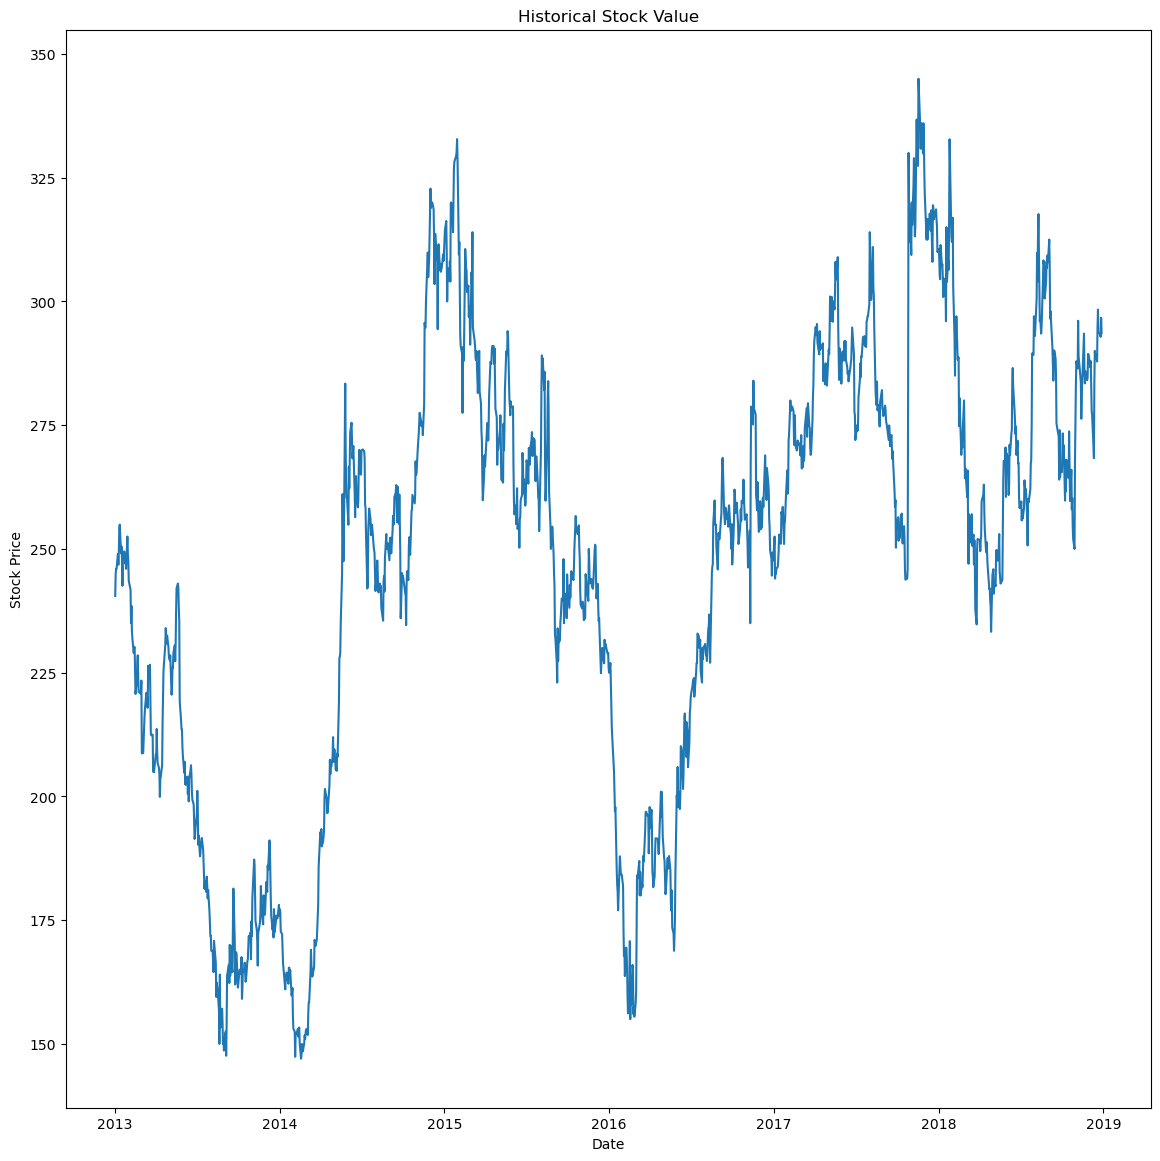

In [7]:
#We can visualise the fetched data in the above step. 
#For simplicity, only the day-wise opening prices are visualised.
plt.figure(figsize=(14,14))
plt.plot(stk_data['Open'])
plt.title('Historical Stock Value')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()


In [8]:
#There are 12 columns in the fetched data. Many of the columns are not of our interest 
#so only significant columns are selected to create the main dataset.
stk_data['Date'] = stk_data.index
data2 = pd.DataFrame(columns = ['Date', 'Open', 'High', 'Low', 'Close'])
data2['Date'] = stk_data['Date']
data2['Open'] = stk_data['Open']
data2['High'] = stk_data['High']
data2['Low'] = stk_data['Low']
data2['Close'] = stk_data['Close']

In [9]:
data2.head()



,Date,Open,High,Low,Close
Date,,,,,
2013-01-01,2013-01-01,240.490005,243.404999,239.755005,242.645004
2013-01-02,2013-01-02,245.000000,246.399994,243.815002,245.054993
2013-01-03,2013-01-03,246.000000,248.240005,243.619995,247.160004
2013-01-04,2013-01-04,246.000000,249.294998,245.065002,248.669998
2013-01-07,2013-01-07,249.000000,249.899994,246.175003,246.759995


In [10]:
data2.shape
#data2.iloc[:, 1:2].values



(1477, 5)

In [11]:
# Preprocess the data in order to prepare it for the LSTM model. 
#The data fetched in step one is used for training purpose only.
train_set = data2.iloc[:, 1:2].values
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_set)
X_train = []
y_train = []
for i in range(60, 1477):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [12]:
X_train.shape

(1417, 60, 1)

In [13]:
y_train.shape

(1417,)

In [14]:
# Define the LSTM Recurrent Neural Network. 
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))


In [23]:
#Compile and train the model 
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs = 5, batch_size = 32)


Epoch 1/5
45/45 [==============================] - 16s 124ms/step - loss: 0.0117
Epoch 2/5
45/45 [==============================] - 6s 129ms/step - loss: 0.0086
Epoch 3/5
45/45 [==============================] - 5s 121ms/step - loss: 0.0075
Epoch 4/5
45/45 [==============================] - 6s 132ms/step - loss: 0.0072
Epoch 5/5
45/45 [==============================] - 6s 124ms/step - loss: 0.0070


In [24]:
#Model needs to be tested on the testing data. 
#For this purpose, fetch the new data for a different period. 
testdataframe= gh.download('SBIN.NS',start=dt.datetime(2019,1,1),end=dt.datetime(2019,9,18))
testdataframe['Date'] = testdataframe.index
testdata = pd.DataFrame(columns = ['Date', 'Open', 'High', 'Low', 'Close'])
testdata['Date'] = testdataframe['Date']
testdata['Open'] = testdataframe['Open']
testdata['High'] = testdataframe['High']
testdata['Low'] = testdataframe['Low']
testdata['Close'] = testdataframe['Close']
real_stock_price = testdata.iloc[:, 1:2].values
dataset_total = pd.concat((data2['Open'], testdata['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(testdata) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 235):
    X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)
print(X_test.shape)
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#X_test = np.reshape(X_test, (X_test.shape[0], 1, 1))


[*********************100%***********************]  1 of 1 completed
(175,)


C:\Users\manan\AppData\Local\Temp\ipykernel_14688\3967128466.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test = np.array(X_test)


In [25]:
X_test = X_test[:-1]

In [26]:
# X_test.shape[1], type(X_test), X_train.shape, 
X_test_ = pd.DataFrame()
i = 0
# value of i define time span
if i < 60:
    for x in X_test:
        temp = []
        for x_ in x:
            temp.append(x_)

        X_test_[i] = temp
        i = i+1
        
X_test = X_test_.T

C:\Users\manan\AppData\Local\Temp\ipykernel_14688\1065922181.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test_[i] = temp
C:\Users\manan\AppData\Local\Temp\ipykernel_14688\1065922181.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test_[i] = temp
C:\Users\manan\AppData\Local\Temp\ipykernel_14688\1065922181.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(ax

In [27]:
X_test.shape

(174, 60)

In [28]:
X_test = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))

In [29]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

6/6 [==============================] - 2s 41ms/step


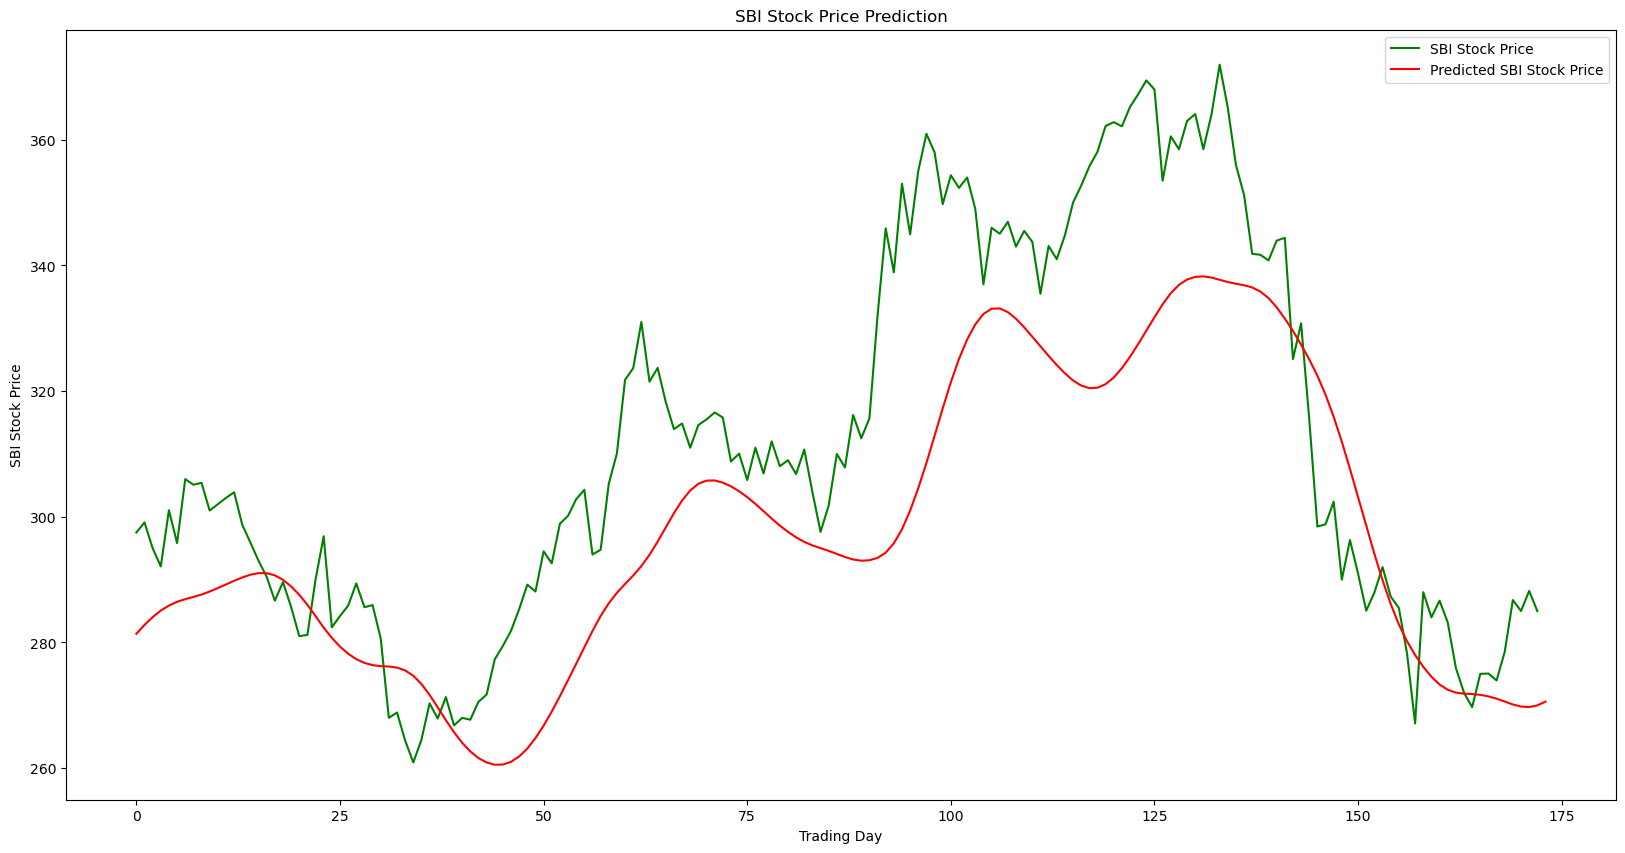

In [30]:
#plotting prediction
plt.figure(figsize=(20,10))
plt.plot(real_stock_price, color = 'green', label = 'SBI Stock Price')
plt.plot(predicted_stock_price, color = 'red', label = 'Predicted SBI Stock Price')
plt.title('SBI Stock Price Prediction')
plt.xlabel('Trading Day')
plt.ylabel('SBI Stock Price')
plt.legend()
plt.show()